<a href="https://colab.research.google.com/github/MWFK/Time_Series_and_Sequence_with_TensorFlow/blob/main/3-Windowed_BI_LSTM(synthetic_data).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tf-nightly-2.0-preview

ERROR: Could not find a version that satisfies the requirement tf-nightly-2.0-preview (from versions: none)
ERROR: No matching distribution found for tf-nightly-2.0-preview


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.2.0


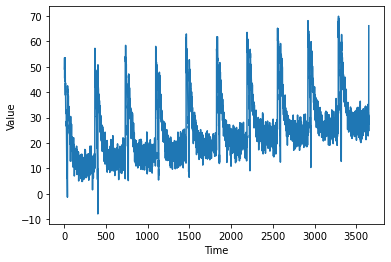

In [ ]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(False)

def trend(time, slope=0):
    return slope * time

# A seasonal pattern occurs when a time series is affected by seasonal factors such as the time of the year or the day of the week. 
# https://robjhyndman.com/hyndsight/cyclicts/
# Define the pattern
def seasonal_pattern(season_time):
    """Just an arbitrary pattern"""
    return np.where(season_time < 0.1,
                    np.cos(season_time * 6 * np.pi),
                    2 / np.exp(9 * season_time))

# Define the amplitude, period, phase
def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)


# Seasonality is always of a fixed and known frequency.
# https://otexts.com/fpp2/tspatterns.html
def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(10 * 365 + 1, dtype="float32") # 10 years worth of random data (data format is array)
baseline = 10
series = trend(time, 0.1)  
baseline = 10 # Starting amplitude point
amplitude = 40
slope = 0.005
noise_level = 3

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=51) # Araay is the favorite format for Tensorflow models

# Define training data (series and time)
split_time = 3000 # The split time depends on the number of data points we have

# Define Training (series and time)
time_train = time[:split_time] # Starts from 0, end in 3000
x_train = series[:split_time] 

# Define validation (series and time) 
time_valid = time[split_time:]  # # Starts from 3000, ends by the end of the array
x_valid = series[split_time:]

window_size = 20 # Almost one month, we're going to use it as a feature, to predict the next value, which will be our label. It can depend on the periodicity of the data.
# define a flat minimizer ¯x as one for which the function varies slowly in a relatively large neighborhood of x. In contrast, a sharp minimizer x is such that the function increases rapidly in a small neighborhood of x.
# https://openreview.net/pdf?id=H1oyRlYgg
# Tradeoff batch size vs. number of iterations 
# https://stats.stackexchange.com/questions/164876/tradeoff-batch-size-vs-number-of-iterations-to-train-a-neural-network
# The lack of generalization ability is due to the fact that large-batch methods tend to converge to sharp minimizers of the training function, and small-batch size tend to converge to flat minimizers.

batch_size = 32
shuffle_buffer_size = 1000

# Series Visualization
plot_series(time, series)

In [ ]:
# We take a window of the data and we train an ML model to predict next value
# Feature is input; label is output; A feature is one column of the data in your input set.
# Once you've trained your model, you will give it sets of new input containing those features; it will return the predicted "label".
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  # from_tensors combines the input and returns a dataset with a single element:# [[1, 2], [3, 4]]
  # from_tensor_slices creates a dataset with a separate element for each row of the input tensor: # [1, 2], [3, 4]
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  # Window the data into chunks of five items whith a shift of one each time, and drop reminder to eliminate the shorter five items
  #for window_dataset in dataset:
    #for val in window_dataset:
      #print(val.numpy(), end="")
    #print()
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  # Use flat_map if you want to make sure that the order of the dataset stays the same. For example, to flatten a dataset of batches into a dataset of their elements:
  # https://www.tensorflow.org/api_docs/python/tf/data/Dataset#flat_map
  # Tensorflow prefers it's data to be in numpy format
  #for window_dataset in dataset:
    #print(window.numy())
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  # Split the data into features and labels # All the columns except last, and the last column
    #for x,y in dataset :
      #print(x.numpy(),y.numpy())

  # Most dataset input pipelines should end with a call to prefetch. This allows later elements to be prepared while the current element is being processed
  # https://www.tensorflow.org/api_docs/python/tf/data/Dataset
  dataset = dataset.batch(batch_size).prefetch(1)
  # We'll be having 2 features and two labels
  #for x,y in dataset :
    #print("x = ", x.numpy())
    #print("y = ", y.numpy())
  return dataset

In [ ]:
# https://www.tensorflow.org/api_docs/python/tf/keras/backend/clear_session
# A common use-case for clear_session is releasing memory when building models and layers in a loop.
# Clears any internal variables, which means models will not impact later versions of themselves
tf.keras.backend.clear_session()

# This sets the graph-level seed.
# https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/random/set_seed
tf.random.set_seed(51)

# I's for operation level
np.random.seed(51)

# https://www.tensorflow.org/api_docs/python/tf/keras/backend/clear_session
# A common use-case for clear_session is releasing memory when building models and layers in a loop.
tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

# Windowed BI-LSTM
model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),# Given a tensor input, this operation inserts a dimension of size 1 at the dimension index axis of input's shape. 
                                                               # https://www.tensorflow.org/api_docs/python/tf/expand_dims
                      input_shape=[None]),     # This means that the model can take sequences of any length

  # The windowed_dataset() return two dimensional batches, with the first being the batch size and the second being the number of timesteps 
  # But the RNN expects three dimensions, so the lambda layer, help fix the difference in dimensions, by adding expannding the array by one dimension

  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),

  # input a sequence and don't output it, except for the last one (sequence to vector RNN), which is the default behavior of Keras TF, 
  # otherwise we set the return_sequence=False and we we'll have (sequence to sequence)

  # The output of the layer is three dimensionals [batch_size * number_units(nulber of units in a cell) * overall_steps(number of cells)]

  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 10.0)

  # For example the activation function of the RNN use tanH functino which have values between -1 and 1, 
  # so we multipky the output by 100, so we can have the regular values of our input time series.
])

# Tune the learning rate by changing it from 10^8 to 10^6
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), # Less sensitive to outliers
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
94/94 [==============================] - 1s 10ms/step - loss: 20.3828 - mae: 20.8828 - lr: 1.0000e-08
Epoch 2/100
94/94 [==============================] - 1s 10ms/step - loss: 20.3543 - mae: 20.8543 - lr: 1.1220e-08
Epoch 3/100
94/94 [==============================] - 1s 10ms/step - loss: 20.3218 - mae: 20.8218 - lr: 1.2589e-08
Epoch 4/100
94/94 [==============================] - 1s 10ms/step - loss: 20.2852 - mae: 20.7851 - lr: 1.4125e-08
Epoch 5/100
94/94 [==============================] - 1s 10ms/step - loss: 20.2436 - mae: 20.7436 - lr: 1.5849e-08
Epoch 6/100
94/94 [==============================] - 1s 10ms/step - loss: 20.1964 - mae: 20.6964 - lr: 1.7783e-08
Epoch 7/100
94/94 [==============================] - 1s 10ms/step - loss: 20.1429 - mae: 20.6429 - lr: 1.9953e-08
Epoch 8/100
94/94 [==============================] - 1s 10ms/step - loss: 20.0823 - mae: 20.5823 - lr: 2.2387e-08
Epoch 9/100
94/94 [==============================] - 1s 9ms/step - loss: 20.0140 - mae: 

(1e-08, 0.0001, 0.0, 30.0)

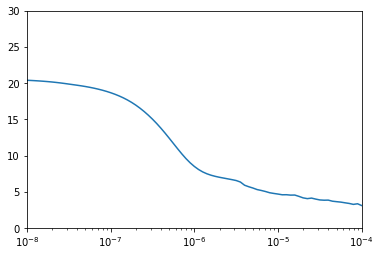

In [ ]:
# Testing the Learning Rate per epoch to use for the full training
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

# We have not addd the learning rate scheduler, because we have determined the good learning rate
model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9),metrics=["mae"]) # Why put mse for loss and mae for metric ???
# In  the previous cell we have uese Huber loss and now mse, and I think because SGD needs the Learning Rate to be specified, so we used to have the Learning Rate scheduler
# And when we're trying to look for the adequate LR it's better to use an optimizer less sensitiveto outliers.
# Yet we have kept the same metric, because a comparaison between the two model wouldn't be fair if we use diffrentmetrics  
history = model.fit(dataset,epochs=500,verbose=1)

Epoch 1/500
94/94 [==============================] - 1s 10ms/step - loss: 263.1988 - mae: 10.1378
Epoch 2/500
94/94 [==============================] - 1s 9ms/step - loss: 33.6153 - mae: 3.9017
Epoch 3/500
94/94 [==============================] - 1s 9ms/step - loss: 27.7103 - mae: 3.5518
Epoch 4/500
94/94 [==============================] - 1s 9ms/step - loss: 31.9160 - mae: 3.9759
Epoch 5/500
94/94 [==============================] - 1s 9ms/step - loss: 27.1127 - mae: 3.5515
Epoch 6/500
94/94 [==============================] - 1s 9ms/step - loss: 25.7764 - mae: 3.4461
Epoch 7/500
94/94 [==============================] - 1s 10ms/step - loss: 32.1397 - mae: 3.9959
Epoch 8/500
94/94 [==============================] - 1s 9ms/step - loss: 27.8369 - mae: 3.6121
Epoch 9/500
94/94 [==============================] - 1s 9ms/step - loss: 29.2938 - mae: 3.8187
Epoch 10/500
94/94 [==============================] - 1s 9ms/step - loss: 28.0733 - mae: 3.6757
Epoch 11/500
94/94 [=========================

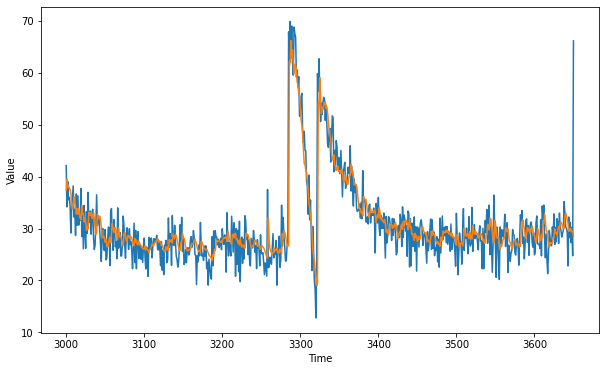

In [ ]:
# Now the model was trained on the data (x_train and validated against x_valid), ut's time to forecast all the series
# We can make a function for the prediction
forecast = []
results = []
# It's a forcasting, so we're comparing t with t+1, => window with next window
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis])) # Actual time until actual time + window_size, thus we're predicting value point one step aat a time
                                                                              # the [] that comes after numpy code defines the output shape
                                                                              # np.newaxis reshapes it to the input dimension that is used by the model

forecast = forecast[split_time-window_size:] # the last value: 2980 till the end, we don't get in the for loop, because it's shifted
results = np.array(forecast)[:, 0, 0]# without [:, 0, 0], the conversion is not possible
                                     # [:, 0] => [26.124496][28.934755][28.08256 ][24.812714]
                                     # [:, 0, 0] => 26.124496 28.934755 28.08256 24.812714


# Visualize the the real series against the predicted series
plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [ ]:
# The less the better
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

2.9205337

<Figure size 432x288 with 0 Axes>

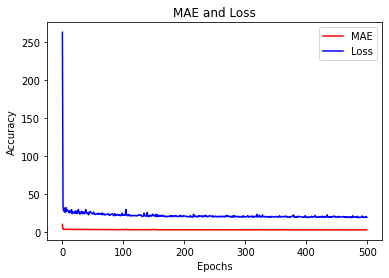

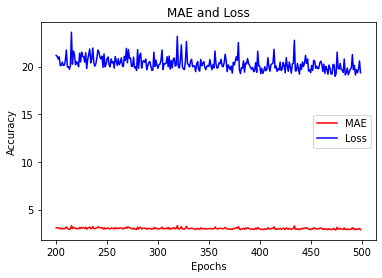

<Figure size 432x288 with 0 Axes>

In [ ]:
# Visualize the Metric(MAE) against the Loss(MSE)

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()